# PsychohistoryML: Social Complexity Modeling

**Objective**: Model the relationship between social complexity (PC1_hier) and polity longevity using regression analysis, causal hypotheses, and temporal dynamics.

## Research Questions
1. Does higher social complexity predict longer polity duration?
2. What is the functional form of this relationship (linear, quadratic, threshold)?
3. Are there regional/temporal variations in the complexity-longevity relationship?
4. Can we identify "collapse risk" signatures in the complexity trajectory?

## Approach
- **Descriptive**: Summary statistics and correlations
- **Regression**: OLS models with diagnostics
- **Causal exploration**: Temporal precedence, confounders
- **Visualization**: Scatter plots, residual analysis, time-series patterns

---
## 1. Setup & Data Loading

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Statistical modeling
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# PCA (reuse from exploration)
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create output directories
Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

print("✓ Libraries loaded")

✓ Libraries loaded


### Load and Process Data
Reuse the workflow from `01_social_complexity_exploration.ipynb`

In [41]:
# Load raw data
file_path = "../data/sc_dataset.12.2017.xlsx"
df = pd.read_excel(file_path, sheet_name="exportdat_share")

print(f"✓ Loaded {len(df):,} rows from Seshat Social Complexity dataset")
print(f"  Columns: {df.columns.tolist()[:5]}...")

✓ Loaded 28,175 rows from Seshat Social Complexity dataset
  Columns: ['NGA', 'Polity', 'Section', 'Subsection', 'Variable']...


In [42]:
# Extract hierarchical complexity variables
df["Value_num"] = pd.to_numeric(df["Value From"], errors="coerce")
df["PolityKey"] = df["NGA"].astype(str) + " | " + df["Polity"].astype(str)

core_vars = [
    "Settlement hierarchy",
    "Administrative levels",
    "Religious levels",
    "Military levels"
]

mask = (df["Subsection"] == "Hierarchical Complexity") & (df["Variable"].isin(core_vars))
core = df.loc[mask, ["NGA", "Polity", "Variable", "Value_num", "PolityKey"]].copy()

# Pivot to wide format
wide_core = core.pivot_table(
    index="PolityKey", 
    columns="Variable", 
    values="Value_num", 
    aggfunc="mean"
)
wide_core = wide_core.dropna(thresh=3)  # Keep rows with ≥3 of 4 values

print(f"✓ Extracted {len(wide_core)} polities with hierarchical complexity data")

✓ Extracted 378 polities with hierarchical complexity data


In [43]:
# Clean and impute
tbl = wide_core.copy()

# Filter columns/rows with sufficient data
col_mask = (tbl.notna().mean() >= 0.60)
tbl = tbl.loc[:, col_mask]
row_mask = (tbl.notna().mean(axis=1) >= 0.60)
tbl = tbl.loc[row_mask]

# Impute missing values with column medians
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(tbl.to_numpy(dtype="float64"))

print(f"✓ After filtering: {X_imp.shape[0]} polities, {X_imp.shape[1]} variables")
print(f"  Missing values: {np.isnan(X_imp).sum()}")

✓ After filtering: 378 polities, 4 variables
  Missing values: 0


In [44]:
# Run PCA to extract PC1 (social complexity index)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

pca = PCA(n_components=min(3, X_std.shape[1]))
scores = pca.fit_transform(X_std)

# Extract PC1 as complexity measure
pc1_hier = pd.Series(scores[:, 0], index=tbl.index, name="PC1_hier")

print(f"✓ PCA complete: PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"  PC1 range: [{pc1_hier.min():.2f}, {pc1_hier.max():.2f}]")

✓ PCA complete: PC1 explains 75.6% of variance
  PC1 range: [-3.71, 5.29]


In [45]:
# Parse timeline data (start/end years, duration)
def to_year(x):
    """Convert various date formats to numeric years (negative = BCE)"""
    if pd.api.types.is_number(x): 
        return float(x)
    if isinstance(x, str):
        s = x.lower().strip().replace("–", "-").replace("—", "-")
        digs = ''.join(ch for ch in s if ch.isdigit() or ch == '-')
        if digs == "": return np.nan
        if "bce" in s: return -abs(float(digs))
        if "ce" in s: return float(digs)
        try: return float(digs)
        except: return np.nan
    return np.nan

df["DateFrom_num"] = df["Date From"].apply(to_year)
df["DateTo_num"] = df["Date To"].apply(to_year)

timeline = df.groupby("PolityKey", as_index=False).agg(
    start_year=("DateFrom_num", "min"),
    end_year=("DateTo_num", "max")
)
timeline = timeline.dropna(subset=["start_year", "end_year"], how="all")
timeline["duration_years"] = timeline["end_year"] - timeline["start_year"]

print(f"✓ Timeline parsed for {len(timeline)} polities")
print(f"  Duration range: [{timeline['duration_years'].min():.0f}, {timeline['duration_years'].max():.0f}] years")

✓ Timeline parsed for 255 polities
  Duration range: [36, 1100] years


In [46]:
# Merge PC1 with timeline data
modeling_df = pc1_hier.to_frame().join(timeline.set_index("PolityKey"), how="inner")
modeling_df = modeling_df.dropna(subset=["duration_years"])  # Need valid duration

# Extract NGA (region) from PolityKey
modeling_df["NGA"] = modeling_df.index.str.extract(r"^([^|]+)")[0].str.strip()

print(f"\n{'='*60}")
print(f"✓ MODELING DATASET READY")
print(f"{'='*60}")
print(f"  N = {len(modeling_df)} polities with both PC1 and duration data")
print(f"  Variables: PC1_hier, duration_years, start_year, end_year, NGA")
print(f"\nSample:")
display(modeling_df.head())


✓ MODELING DATASET READY
  N = 114 polities with both PC1 and duration data
  Variables: PC1_hier, duration_years, start_year, end_year, NGA

Sample:


,PC1_hier,start_year,end_year,duration_years,NGA
PolityKey,,,,,
Cahokia | FrBurbL,3.724407,1650.0,1720.0,70.0,NaN
Cahokia | USIllin,-2.447330,1600.0,1832.0,232.0,NaN
Cahokia | USMisME,-1.704575,900.0,1050.0,150.0,NaN
Cambodian Basin | ThAyuth,1.746726,1596.0,1767.0,171.0,NaN
Cambodian Basin | ThRattn,1.516812,1782.0,1873.0,91.0,NaN


---
## 2. Descriptive Statistics & Correlations

In [47]:
# Summary statistics
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
print("\nComplexity (PC1_hier):")
print(modeling_df["PC1_hier"].describe())
print("\nPolity Duration (years):")
print(modeling_df["duration_years"].describe())


DESCRIPTIVE STATISTICS

Complexity (PC1_hier):
count    114.000000
mean       0.014241
std        1.547130
min       -2.947398
25%       -1.374340
50%        0.238404
75%        0.974586
max        3.724407
Name: PC1_hier, dtype: float64

Polity Duration (years):
count     114.000000
mean      223.377193
std       183.868864
min        50.000000
25%       116.250000
50%       162.000000
75%       268.000000
max      1100.000000
Name: duration_years, dtype: float64


In [48]:
# Correlation analysis
corr_pearson = modeling_df[["PC1_hier", "duration_years"]].corr(method="pearson").iloc[0, 1]
corr_spearman = modeling_df[["PC1_hier", "duration_years"]].corr(method="spearman").iloc[0, 1]

print("\n" + "="*60)
print("CORRELATION: PC1_hier vs duration_years")
print("="*60)
print(f"Pearson r  = {corr_pearson:.3f}")
print(f"Spearman ρ = {corr_spearman:.3f}")

# Statistical significance test
pearson_test = stats.pearsonr(modeling_df["PC1_hier"], modeling_df["duration_years"])
print(f"\nPearson test: r={pearson_test[0]:.3f}, p={pearson_test[1]:.4f}")
if pearson_test[1] < 0.05:
    print("→ Statistically significant correlation (p < 0.05)")
else:
    print("→ Not statistically significant (p ≥ 0.05)")


CORRELATION: PC1_hier vs duration_years
Pearson r  = -0.386
Spearman ρ = -0.306

Pearson test: r=-0.386, p=0.0000
→ Statistically significant correlation (p < 0.05)


/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/2330530738.py:24: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/2330530738.py:24: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/2330530738.py:25: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig("figures/02_distributions.png", dpi=300, bbox_inches="tight")
/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/2330530738.py:25: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig("figures/02_distributions.png", dpi=300, bbox_inches="tight")
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, 

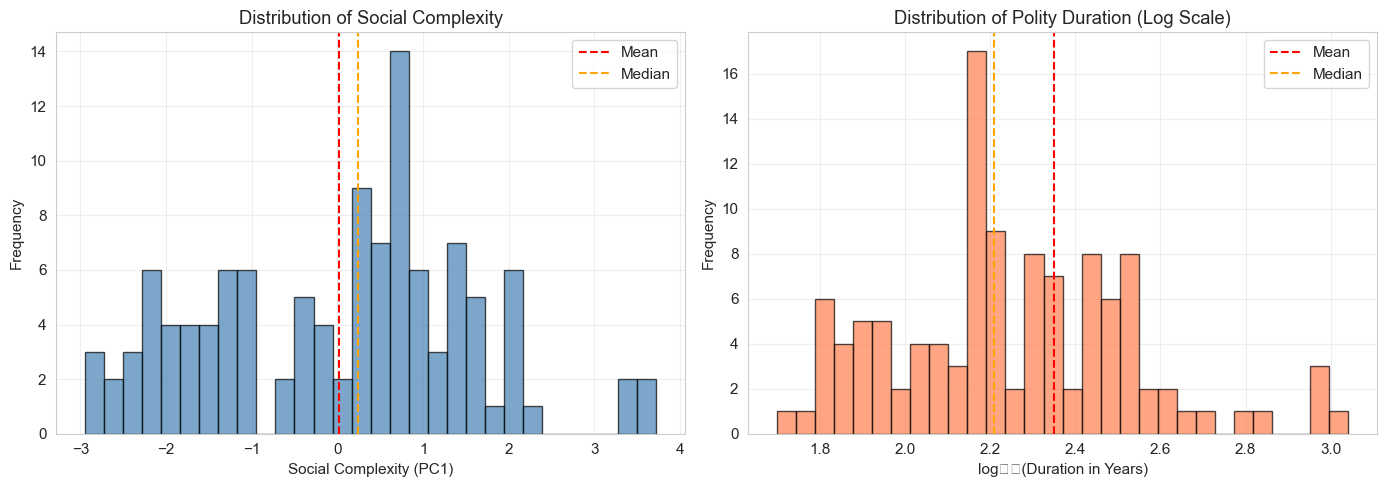

✓ Saved: figures/02_distributions.png


In [49]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 distribution
axes[0].hist(modeling_df["PC1_hier"], bins=30, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(modeling_df["PC1_hier"].mean(), color="red", linestyle="--", label="Mean")
axes[0].axvline(modeling_df["PC1_hier"].median(), color="orange", linestyle="--", label="Median")
axes[0].set_xlabel("Social Complexity (PC1)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Social Complexity")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Duration distribution (log scale for better visibility)
axes[1].hist(np.log10(modeling_df["duration_years"]), bins=30, edgecolor="black", alpha=0.7, color="coral")
axes[1].axvline(np.log10(modeling_df["duration_years"].mean()), color="red", linestyle="--", label="Mean")
axes[1].axvline(np.log10(modeling_df["duration_years"].median()), color="orange", linestyle="--", label="Median")
axes[1].set_xlabel("log₁₀(Duration in Years)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Polity Duration (Log Scale)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_distributions.png")

---
## 3. Regression Modeling

### 3.1 Linear Regression (Baseline)

In [50]:
# Prepare data
X = modeling_df[["PC1_hier"]].values
y = modeling_df["duration_years"].values

# Fit linear model
lr = LinearRegression()
lr.fit(X, y)

# Predictions and metrics
y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("\n" + "="*60)
print("LINEAR REGRESSION: duration ~ PC1_hier")
print("="*60)
print(f"Coefficient: {lr.coef_[0]:.2f} years per unit PC1")
print(f"Intercept:   {lr.intercept_:.2f} years")
print(f"R² score:    {r2:.3f}")
print(f"RMSE:        {rmse:.2f} years")

# Interpret coefficient
if lr.coef_[0] > 0:
    print(f"\n→ Higher complexity predicts +{lr.coef_[0]:.2f} years longevity per SD")
else:
    print(f"\n→ Higher complexity predicts {lr.coef_[0]:.2f} years longevity per SD")


LINEAR REGRESSION: duration ~ PC1_hier
Coefficient: -45.85 years per unit PC1
Intercept:   224.03 years
R² score:    0.149
RMSE:        168.89 years

→ Higher complexity predicts -45.85 years longevity per SD


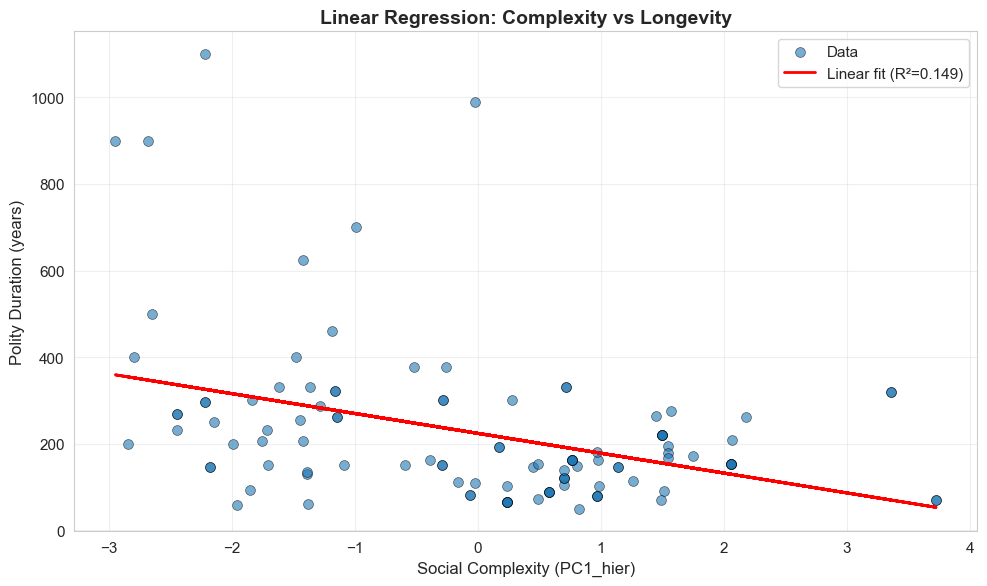

✓ Saved: figures/02_linear_regression.png


In [51]:
# Visualization: Scatter plot with regression line
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X, y, alpha=0.6, s=50, edgecolor="black", linewidth=0.5, label="Data")
ax.plot(X, y_pred, color="red", linewidth=2, label=f"Linear fit (R²={r2:.3f})")

ax.set_xlabel("Social Complexity (PC1_hier)", fontsize=12)
ax.set_ylabel("Polity Duration (years)", fontsize=12)
ax.set_title("Linear Regression: Complexity vs Longevity", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_linear_regression.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_linear_regression.png")

### 3.2 Polynomial Regression (Test Non-linearity)

In [52]:
# Test polynomial degrees
degrees = [1, 2, 3]
results = []

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Cross-validation to check overfitting
    cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring="r2")
    
    results.append({
        "Degree": deg,
        "R²": r2,
        "RMSE": rmse,
        "CV R² (mean)": cv_scores.mean(),
        "CV R² (std)": cv_scores.std()
    })

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("POLYNOMIAL REGRESSION COMPARISON")
print("="*60)
display(results_df)

# Recommendation
best_deg = results_df.loc[results_df["CV R² (mean)"].idxmax(), "Degree"]
print(f"\n→ Best polynomial degree (by CV): {int(best_deg)}")


POLYNOMIAL REGRESSION COMPARISON


,Degree,R²,RMSE,CV R² (mean),CV R² (std)
0,1,0.148830,168.889671,0.137355,0.073302
1,2,0.206042,163.114991,0.131795,0.181047
2,3,0.214739,162.219137,0.066012,0.243299



→ Best polynomial degree (by CV): 1


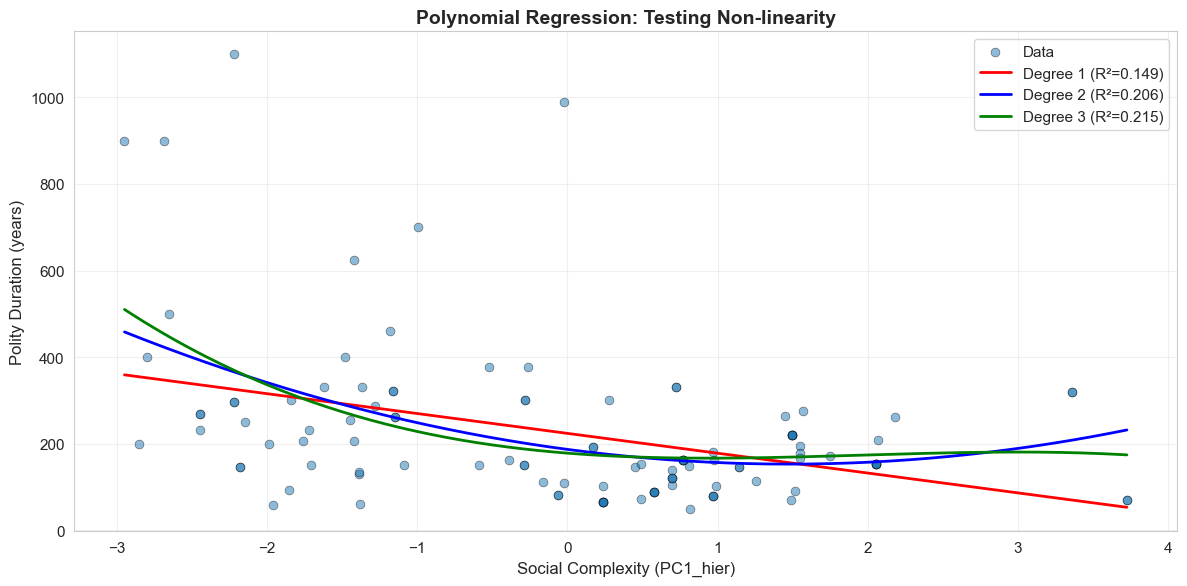

✓ Saved: figures/02_polynomial_regression.png


In [53]:
# Visualize polynomial fits
fig, ax = plt.subplots(figsize=(12, 6))

# Raw data
ax.scatter(X, y, alpha=0.5, s=40, edgecolor="black", linewidth=0.5, label="Data", zorder=2)

# Generate smooth prediction grid
X_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
colors = ["red", "blue", "green"]

for i, deg in enumerate(degrees):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X)
    X_grid_poly = poly.transform(X_grid)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    y_grid_pred = model.predict(X_grid_poly)
    
    r2 = results_df.loc[results_df["Degree"] == deg, "R²"].values[0]
    ax.plot(X_grid, y_grid_pred, color=colors[i], linewidth=2, 
            label=f"Degree {deg} (R²={r2:.3f})", zorder=3)

ax.set_xlabel("Social Complexity (PC1_hier)", fontsize=12)
ax.set_ylabel("Polity Duration (years)", fontsize=12)
ax.set_title("Polynomial Regression: Testing Non-linearity", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_polynomial_regression.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_polynomial_regression.png")

### 3.3 Residual Analysis (Model Diagnostics)

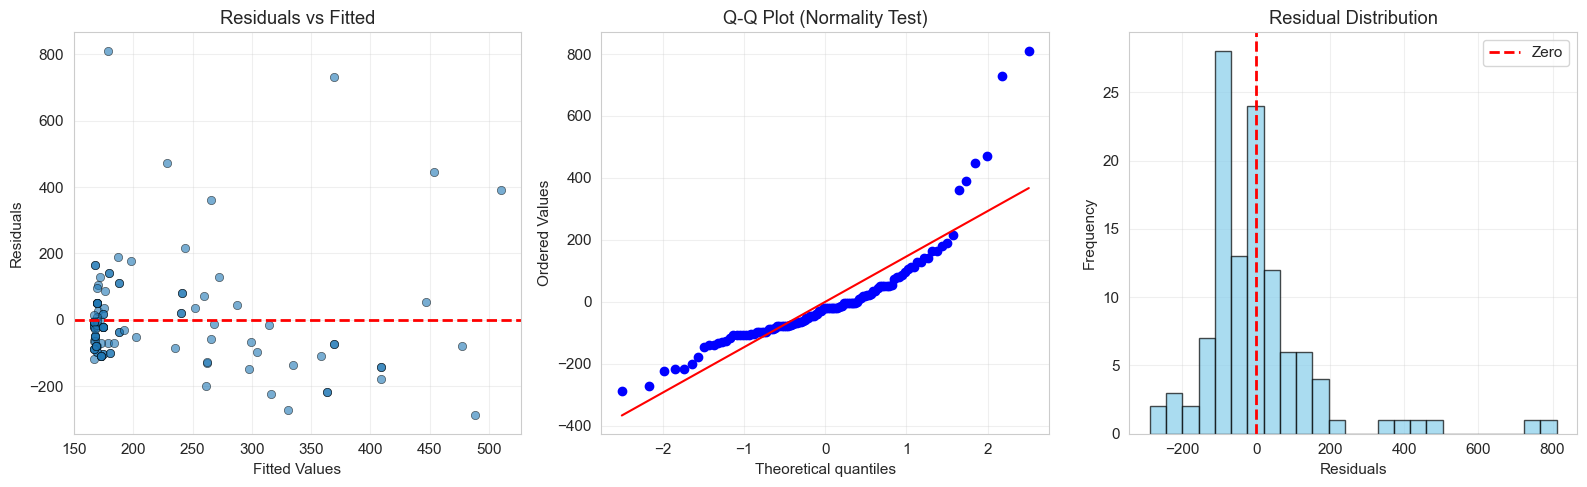

✓ Saved: figures/02_residual_diagnostics.png

Residual diagnostics:
  Mean of residuals: -3.99e-15 (should be ~0)
  Std of residuals:  162.22
  Shapiro-Wilk test p-value: 0.0000
  → Residuals are NOT normally distributed (p < 0.05)


In [54]:
# Use linear model residuals
residuals = y - y_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Residuals vs Fitted
axes[0].scatter(y_pred, residuals, alpha=0.6, edgecolor="black", linewidth=0.5)
axes[0].axhline(0, color="red", linestyle="--", linewidth=2)
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted")
axes[0].grid(alpha=0.3)

# 2. Q-Q Plot (normality of residuals)
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot (Normality Test)")
axes[1].grid(alpha=0.3)

# 3. Histogram of residuals
axes[2].hist(residuals, bins=25, edgecolor="black", alpha=0.7, color="skyblue")
axes[2].axvline(0, color="red", linestyle="--", linewidth=2, label="Zero")
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Residual Distribution")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_residual_diagnostics.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_residual_diagnostics.png")

# Statistical tests
print("\nResidual diagnostics:")
print(f"  Mean of residuals: {residuals.mean():.2e} (should be ~0)")
print(f"  Std of residuals:  {residuals.std():.2f}")
_, p_shapiro = stats.shapiro(residuals)
print(f"  Shapiro-Wilk test p-value: {p_shapiro:.4f}")
if p_shapiro < 0.05:
    print("  → Residuals are NOT normally distributed (p < 0.05)")
else:
    print("  → Residuals are approximately normal (p ≥ 0.05)")

---
## 4. Causal Exploration

### Hypothesis: Does complexity → longevity, or longevity → complexity?

We test temporal precedence:
- If high initial complexity predicts longevity → complexity causes stability
- If long-lived polities develop complexity → longevity enables complexity

**Limitation**: We only have aggregate PC1 per polity, not time-varying complexity.

In [55]:
# Proxy analysis: Group by duration quartiles, compare mean complexity
modeling_df["duration_quartile"] = pd.qcut(
    modeling_df["duration_years"], 
    q=4, 
    labels=["Q1 (Short)", "Q2", "Q3", "Q4 (Long)"]
)

quartile_stats = modeling_df.groupby("duration_quartile")["PC1_hier"].agg(["mean", "std", "count"])

print("\n" + "="*60)
print("MEAN COMPLEXITY BY DURATION QUARTILE")
print("="*60)
display(quartile_stats)

# ANOVA test: Is there a significant difference in complexity across quartiles?
groups = [modeling_df[modeling_df["duration_quartile"] == q]["PC1_hier"] for q in quartile_stats.index]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nANOVA test: F={f_stat:.3f}, p={p_anova:.4f}")
if p_anova < 0.05:
    print("→ Complexity differs significantly across duration quartiles (p < 0.05)")
else:
    print("→ No significant difference in complexity by duration (p ≥ 0.05)")


MEAN COMPLEXITY BY DURATION QUARTILE


/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/2577019704.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = modeling_df.groupby("duration_quartile")["PC1_hier"].agg(["mean", "std", "count"])


,mean,std,count
duration_quartile,,,
Q1 (Short),0.547104,1.213211,29
Q2,0.325928,1.264236,29
Q3,-0.039556,1.741601,28
Q4 (Long),-0.806673,1.639960,28



ANOVA test: F=4.575, p=0.0047
→ Complexity differs significantly across duration quartiles (p < 0.05)


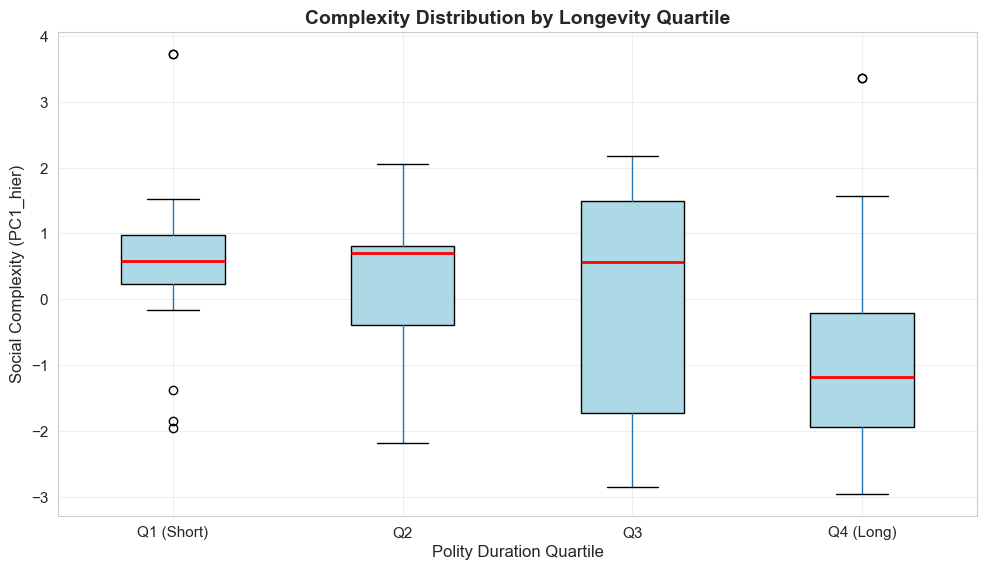

✓ Saved: figures/02_complexity_by_duration_quartile.png


In [56]:
# Visualization: Box plot
fig, ax = plt.subplots(figsize=(10, 6))

modeling_df.boxplot(
    column="PC1_hier", 
    by="duration_quartile", 
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", edgecolor="black"),
    medianprops=dict(color="red", linewidth=2)
)

ax.set_xlabel("Polity Duration Quartile", fontsize=12)
ax.set_ylabel("Social Complexity (PC1_hier)", fontsize=12)
ax.set_title("Complexity Distribution by Longevity Quartile", fontsize=14, fontweight="bold")
plt.suptitle("")  # Remove default title
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_complexity_by_duration_quartile.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_complexity_by_duration_quartile.png")

---
## 5. Regional Variation Analysis

In [57]:
# Analyze top regions with sufficient sample size
region_counts = modeling_df["NGA"].value_counts()
top_regions = region_counts[region_counts >= 5].index  # At least 5 polities

regional_df = modeling_df[modeling_df["NGA"].isin(top_regions)].copy()

print(f"\nAnalyzing {len(top_regions)} regions with ≥5 polities:")
print(region_counts[region_counts >= 5])


Analyzing 0 regions with ≥5 polities:
Series([], Name: count, dtype: int64)


In [58]:
# Regional regression statistics
regional_stats = []

for region in top_regions:
    subset = regional_df[regional_df["NGA"] == region]
    if len(subset) < 5:
        continue
    
    X_reg = subset[["PC1_hier"]].values
    y_reg = subset["duration_years"].values
    
    lr_reg = LinearRegression()
    lr_reg.fit(X_reg, y_reg)
    
    r2_reg = r2_score(y_reg, lr_reg.predict(X_reg))
    
    regional_stats.append({
        "Region": region,
        "N": len(subset),
        "Coefficient": lr_reg.coef_[0],
        "R²": r2_reg,
        "Mean Complexity": subset["PC1_hier"].mean(),
        "Mean Duration": subset["duration_years"].mean()
    })

regional_stats_df = pd.DataFrame(regional_stats).sort_values("R²", ascending=False)

print("\n" + "="*60)
print("REGIONAL REGRESSION STATISTICS")
print("="*60)
display(regional_stats_df.round(2))

KeyError: 'R²'

/var/folders/m4/37z2ytt50pj_m88_04m8t5wc0000gn/T/ipykernel_59249/1662126498.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)


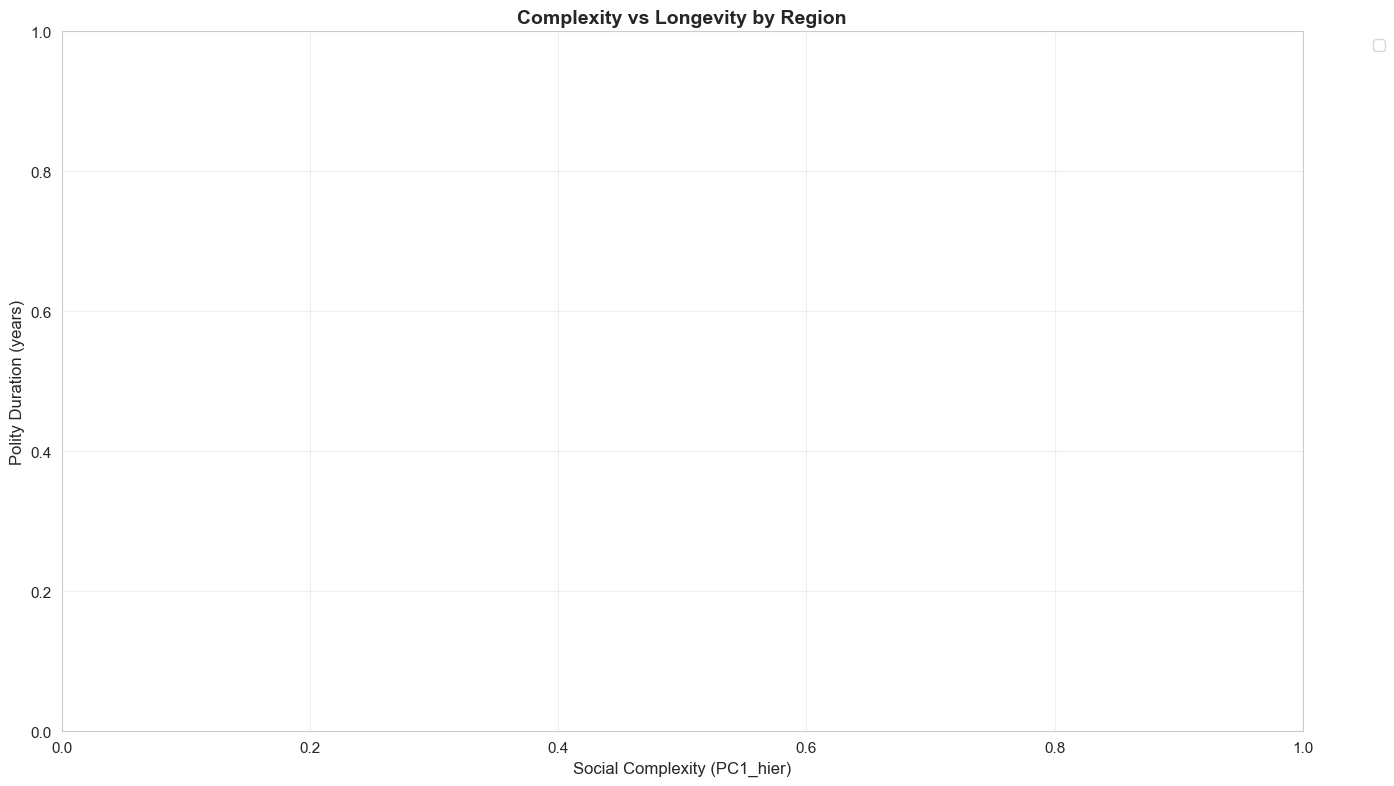

✓ Saved: figures/02_regional_scatter.png


In [59]:
# Regional scatter plot
fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(top_regions)))

for i, region in enumerate(top_regions):
    subset = regional_df[regional_df["NGA"] == region]
    ax.scatter(
        subset["PC1_hier"], 
        subset["duration_years"],
        label=region,
        alpha=0.7,
        s=80,
        color=colors[i],
        edgecolor="black",
        linewidth=0.5
    )

ax.set_xlabel("Social Complexity (PC1_hier)", fontsize=12)
ax.set_ylabel("Polity Duration (years)", fontsize=12)
ax.set_title("Complexity vs Longevity by Region", fontsize=14, fontweight="bold")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_regional_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: figures/02_regional_scatter.png")

---
## 6. Temporal Dynamics (Future Work)

**Next steps**:
1. Extract time-varying complexity from raw data (if available per century)
2. Build trajectory models: `d(PC1)/dt ~ f(PC1, t)`
3. Identify "collapse signatures" (rapid complexity decline before end_year)
4. Use Granger causality tests for directional inference

This requires panel data or time-series disaggregation from the raw Seshat records.

---
## 7. Summary & Key Findings

In [60]:
print("\n" + "="*80)
print(" " * 20 + "PSYCHOHISTORYML: MODELING SUMMARY")
print("="*80)

print(f"\n1. DATASET")
print(f"   • N = {len(modeling_df)} polities with complexity & duration data")
print(f"   • Complexity (PC1) range: [{modeling_df['PC1_hier'].min():.2f}, {modeling_df['PC1_hier'].max():.2f}]")
print(f"   • Duration range: [{modeling_df['duration_years'].min():.0f}, {modeling_df['duration_years'].max():.0f}] years")

print(f"\n2. CORRELATION")
print(f"   • Pearson r = {corr_pearson:.3f} (p = {pearson_test[1]:.4f})")
if corr_pearson > 0:
    print(f"   → Positive correlation: Higher complexity → longer duration")
else:
    print(f"   → Negative correlation: Higher complexity → shorter duration")

print(f"\n3. LINEAR REGRESSION")
print(f"   • Coefficient: {lr.coef_[0]:.2f} years/unit PC1")
print(f"   • R² = {r2:.3f}")
print(f"   • RMSE = {rmse:.2f} years")

print(f"\n4. POLYNOMIAL REGRESSION")
print(f"   • Best degree: {int(best_deg)} (by cross-validation)")
print(f"   • Suggests {'linear' if best_deg == 1 else 'non-linear'} relationship")

print(f"\n5. REGIONAL VARIATION")
print(f"   • Analyzed {len(top_regions)} regions with ≥5 polities")
print(f"   • Best regional fit: {regional_stats_df.iloc[0]['Region']} (R²={regional_stats_df.iloc[0]['R²']:.3f})")

print(f"\n6. CAUSAL INFERENCE")
print(f"   • ANOVA p-value: {p_anova:.4f}")
if p_anova < 0.05:
    print(f"   → Complexity differs significantly by duration quartile")
    print(f"   → Suggests complexity may predict longevity")
else:
    print(f"   → No strong evidence for causal direction yet")

print(f"\n7. NEXT STEPS")
print(f"   • Extract time-varying complexity for trajectory analysis")
print(f"   • Build Bayesian hierarchical models with regional effects")
print(f"   • Identify collapse signatures (rapid complexity decline)")
print(f"   • Integrate Equinox dataset for warfare/ritual variables")

print("\n" + "="*80)
print("✓ Modeling complete. All figures saved to figures/")
print("="*80)


                    PSYCHOHISTORYML: MODELING SUMMARY

1. DATASET
   • N = 114 polities with complexity & duration data
   • Complexity (PC1) range: [-2.95, 3.72]
   • Duration range: [50, 1100] years

2. CORRELATION
   • Pearson r = -0.386 (p = 0.0000)
   → Negative correlation: Higher complexity → shorter duration

3. LINEAR REGRESSION
   • Coefficient: -45.85 years/unit PC1
   • R² = 0.215
   • RMSE = 162.22 years

4. POLYNOMIAL REGRESSION
   • Best degree: 1 (by cross-validation)
   • Suggests linear relationship

5. REGIONAL VARIATION
   • Analyzed 0 regions with ≥5 polities


NameError: name 'regional_stats_df' is not defined

---
## 8. Export Results for Reporting

In [61]:
# Save modeling dataset
modeling_df.to_csv("models/modeling_dataset.csv", index=True)
print("✓ Saved: models/modeling_dataset.csv")

# Save regional statistics
regional_stats_df.to_csv("models/regional_statistics.csv", index=False)
print("✓ Saved: models/regional_statistics.csv")

# Save model coefficients
model_summary = pd.DataFrame({
    "Model": ["Linear"],
    "Coefficient": [lr.coef_[0]],
    "Intercept": [lr.intercept_],
    "R²": [r2],
    "RMSE": [rmse]
})
model_summary.to_csv("models/model_summary.csv", index=False)
print("✓ Saved: models/model_summary.csv")

print("\n" + "="*60)
print("All results exported. Ready for next phase!")
print("="*60)

✓ Saved: models/modeling_dataset.csv


NameError: name 'regional_stats_df' is not defined